<a href="https://colab.research.google.com/github/ckelaid/Covid-19-Tweet-BERT-Sentiment-Analysis/blob/main/Corona_Tweets_Sentiment_Analysis_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle link: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

Before we do anything, we setup our GPU environment:

Step 1: "Edit" => "Notebook settings" => "Hardware accelerator" => 'GPU"

In [1]:
# Step 2

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Some more setting up (SpaCy for language detection for data cleaning process).

In [ ]:
!pip install --upgrade spacy

In [ ]:
!pip install spacy_langdetect

In [ ]:
!python -m spacy download en_core_web_sm

In [6]:
# Using SpaCy for language detection
from spacy_langdetect import LanguageDetector
import spacy
from spacy.language import Language

def get_lang_detector(nlp, name):
  return LanguageDetector()

nlp = spacy.load("en_core_web_sm") #1
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True) #2

Load in train and test data from OneDrive:

In [7]:
import base64

def OneDrive_DirectDownload(onedrive_link):
  data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
  data_bytes64_string = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
  result_url = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_string}/root/content"

  return result_url

In [8]:
import pandas as pd

# Import train set
onedrive_link = 'https://1drv.ms/x/s!Av9ypDUIIPwkgXvcBZcktqG-1YAz?e=7ExdfB'
onedrive_direct_link = OneDrive_DirectDownload(onedrive_link)
print(f"Original OneDrive link: {onedrive_link}")
print(f"Generated Direct Download link: {onedrive_direct_link}")
train = pd.read_excel(onedrive_direct_link)

Original OneDrive link: https://1drv.ms/x/s!Av9ypDUIIPwkgXvcBZcktqG-1YAz?e=7ExdfB
Generated Direct Download link: https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3gvcyFBdjl5cERVSUlQd2tnWHZjQlpja3RxRy0xWUF6P2U9N0V4ZGZC/root/content


In [9]:
# Import test set
onedrive_link = 'https://1drv.ms/x/s!Av9ypDUIIPwkggAHupoH6F3Bxogg?e=AB3pjV'
onedrive_direct_link = OneDrive_DirectDownload(onedrive_link)
print(f"Original OneDrive link: {onedrive_link}")
print(f"Generated Direct Download link: {onedrive_direct_link}")
test = pd.read_excel(onedrive_direct_link)

Original OneDrive link: https://1drv.ms/x/s!Av9ypDUIIPwkggAHupoH6F3Bxogg?e=AB3pjV
Generated Direct Download link: https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3gvcyFBdjl5cERVSUlQd2tnZ0FIdXBvSDZGM0J4b2dnP2U9QUIzcGpW/root/content


In [10]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2020-02-03 00:00:00,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2020-02-03 00:00:00,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2020-02-03 00:00:00,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2020-02-03 00:00:00,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",2020-03-03 00:00:00,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
print(f"TRAINING SET: {train.shape}\nTESTING SET: {test.shape}")

TRAINING SET: (41157, 6)
TESTING SET: (3798, 6)


# Data Cleaning

To begin , we have a few columns to drop from both sets as for this analysis we are only interested in the tweets and their sentiment.

In [ ]:
drop_cols = ['UserName', 'ScreenName', 'Location', 'TweetAt']
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

In [ ]:
train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
# Check for NaNs
train.isnull().sum, test.isnull().sum #No NaNs

(<bound method DataFrame.sum of        OriginalTweet  Sentiment
 0              False      False
 1              False      False
 2              False      False
 3              False      False
 4              False      False
 ...              ...        ...
 41152          False      False
 41153          False      False
 41154          False      False
 41155          False      False
 41156          False      False
 
 [41157 rows x 2 columns]>,
 <bound method DataFrame.sum of       OriginalTweet  Sentiment
 0             False      False
 1             False      False
 2             False      False
 3             False      False
 4             False      False
 ...             ...        ...
 3793          False      False
 3794          False      False
 3795          False      False
 3796          False      False
 3797          False      False
 
 [3798 rows x 2 columns]>)

In [ ]:
#Check for duplicates
train.drop_duplicates(subset='OriginalTweet', inplace=True)

In [ ]:
train.info() #yeah, so no duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 964.6+ KB


## Data cleaning functions

In [ ]:
!pip install emoji

     |████████████████████████████████| 170 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=169180017489f92d60d4fc768910b3f501fdf3b3c603f25d933e5095e734d3e9
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
#data processing
import re, string
import emoji
import nltk

In [ ]:
#Clean emojis
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

#Clean punctuation, links, mentions and newline characters (\r & \n)
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)#links & mentions
    text = re.sub(r'[^\x00-\x7f]', r'', text)#non utf8/ascii characters
    banned_list = string.punctuation +'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#Clean # at end & middle of sentence
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))#remove last #
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
#remove # from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append()
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

In [ ]:
#Calling the cleaning functions on the training set
texts_new_train = []
for t in train.OriginalTweet:
    texts_new_train.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
#Calling the cleaning functions on the test set
texts_new_test = []
for t in test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
# Add the cleaned tweets to the data
train['clean_tweets'] = texts_new_train
test['clean_tweets'] = texts_new_test

#Remove the uncleaned verison of the tweets
train = train.drop('OriginalTweet', axis=1)
test = test.drop('OriginalTweet', axis=1)

In [ ]:
train.head()

,Sentiment,clean_tweets
0,Neutral,and and
1,Positive,advice talk to your neighbours family to excha...
2,Positive,coronavirus australia woolworths to give elder...
3,Positive,my food stock is not the only one which is emp...
4,Extremely Negative,me ready to go at supermarket during the covid...


In [ ]:
test.head()

,Sentiment,clean_tweets
0,Extremely Negative,trending new yorkers encounter empty supermark...
1,Positive,when i couldnt find hand sanitizer at fred mey...
2,Extremely Positive,find out how you can protect yourself and love...
3,Negative,panic buying hits newyork city as anxious shop...
4,Neutral,toiletpaper dunnypaper coronavirus coronavirus...


Let's check the length of the tweets:

In [ ]:
#Length of each tweet (train set)
text_len_train = []
for tweet in train.clean_tweets:
    tweet_len = len(tweet.split())
    text_len_train.append(tweet_len)

#Add it to the data frame
train["Tweet_length"] = text_len_train

In [ ]:
#Length of each tweet (test set)
text_len_test = []
for tweet in test.clean_tweets:
    tweet_len = len(tweet.split())
    text_len_test.append(tweet_len)

test['Tweet_length'] = text_len_test

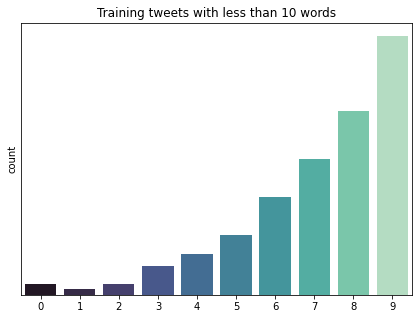

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
ax = sns.countplot(x='Tweet_length', data=train[train['Tweet_length']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
#ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

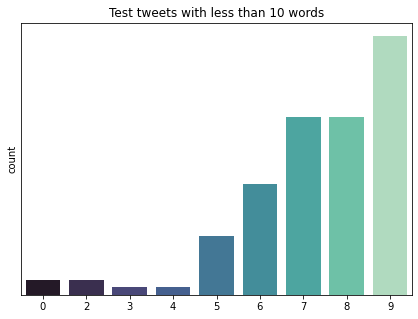

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='Tweet_length', data=test[test['Tweet_length']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
#ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are a few of tweets with 0 words; this is due to the cleaning performed prior. This means that some tweets contained only mentions, hashtags and links, which have been removed. Going forward we drop tweets of length 4 and less.

In [ ]:
print(f"TRAIN SHAPE: {train.shape}")
print(f"TEST SHAPE: {test.shape}")

TRAIN SHAPE: (41157, 3)
TEST SHAPE: (3798, 3)


In [ ]:
train = train[train['Tweet_length']>=4]
test = test[test['Tweet_length']>=4]

print(f"CLEAN_TRAIN SHAPE: {train.shape}")
print(f"CLEAN_TEST SHAPE: {test.shape}")

CLEAN_TRAIN SHAPE: (41029, 3)
CLEAN_TEST SHAPE: (3793, 3)


As we can see, this only removed a small amount of tweets.

In [ ]:
train.head()

,Sentiment,clean_tweets,Tweet_length
1,Positive,advice talk to your neighbours family to excha...,38
2,Positive,coronavirus australia woolworths to give elder...,13
3,Positive,my food stock is not the only one which is emp...,41
4,Extremely Negative,me ready to go at supermarket during the covid...,39
5,Positive,as news of the regions first confirmed covid19...,34


In [ ]:
test.head()

,Sentiment,clean_tweets,Tweet_length
0,Extremely Negative,trending new yorkers encounter empty supermark...,21
1,Positive,when i couldnt find hand sanitizer at fred mey...,29
2,Extremely Positive,find out how you can protect yourself and love...,12
3,Negative,panic buying hits newyork city as anxious shop...,35
4,Neutral,toiletpaper dunnypaper coronavirus coronavirus...,25


## Language-Detection

Before we go through with language detection, let's reorganize both are sets so the indexes are in place.

In [ ]:
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,Sentiment,clean_tweets,Tweet_length
0,Positive,scots vulnerable to are getting increasingly c...,28
1,Negative,given how many of the government have gone dow...,28
2,Negative,well now im starting to worry tesco shelves em...,35
3,Positive,hello have you got any paracetamol in still wh...,41
4,Neutral,norways currency krone has lost about 30 of it...,39


In [ ]:
test = test.sample(frac=1).reset_index(drop=True)
test.head()

,Sentiment,clean_tweets,Tweet_length
0,Extremely Negative,seeing all these pictures of empty shelves is ...,22
1,Neutral,grocery store as of one hour ago11 am on a fri...,13
2,Neutral,bjp mp subramanian swamy has given zero hour n...,27
3,Negative,had to take a high dose cbd capsule today due ...,36
4,Positive,just left a local supermarket amp its just ama...,47


In [ ]:
# Now we perform language detection:

# Train set
nonEnglish_Indexes = []
for i in range(len(train.clean_tweets)):
  doc = nlp(train.clean_tweets[i])
  if doc._.language['language'] != 'en': #Checking for non-english tweets
    nonEnglish_Indexes.append(i) # Storing non-english indexes


In [ ]:
len(nonEnglish_Indexes)

231

In [ ]:
# Test set
nonEnglish_test_Indexes = []
for i in range(len(test.clean_tweets)):
  doc = nlp(test.clean_tweets[i])
  if doc._.language['language'] != 'en': #Checking for non-english tweets
    nonEnglish_test_Indexes.append(i) # Storing non-english indexes

In [ ]:
len(nonEnglish_test_Indexes)

12

In [ ]:
print(f"TRAIN: {train.shape}\nTEST: {test.shape}")

TRAIN: (41029, 3)
TEST: (3793, 3)


In [ ]:
# Dropping non-english tweets

# Train
train = train.drop(nonEnglish_Indexes)
test = test.drop(nonEnglish_test_Indexes)

print(f"TRAIN: {train.shape}\nTEST: {test.shape}")

TRAIN: (40798, 3)
TEST: (3781, 3)


Let's reorganize our indexes one last time, and we can move on to the training and fine-tuning of BERT.

In [ ]:
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [ ]:
train.head()

,Sentiment,clean_tweets,Tweet_length
0,Negative,scammers have been taking advantage of fears s...,23
1,Neutral,for all the grocery store employees covid2019 ...,10
2,Neutral,i know residents in tower hamlets are concerne...,46
3,Negative,my holidaytrip is not for another few months s...,33
4,Extremely Positive,in indiana familyowned indiana safety and supp...,39


In [ ]:
test.head()

,Sentiment,clean_tweets,Tweet_length
0,Neutral,the advice on coronavirus keeps changing what ...,12
1,Negative,how much of the panicbuying food will never be...,17
2,Positive,impacts of corona virus according to economist...,21
3,Extremely Positive,if you have extra unopened handsanitizer amp w...,39
4,Positive,apple store locations have received new direct...,22


# Sentiment Analysis

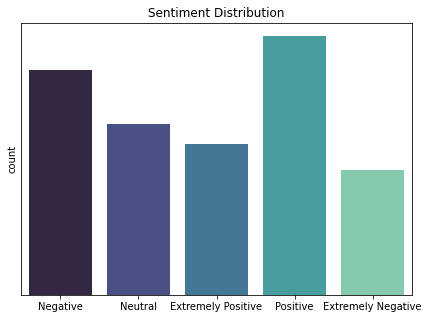

In [ ]:
# Visualise Sentiment

plt.figure(figsize=(7,5))
ax = sns.countplot(x='Sentiment', data=train, palette='mako')
plt.title('Sentiment Distribution')
plt.yticks([])
#ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We want to numerize our classes and limit ourselves to three classes. So something like [0 = Negative, 1 = Neutral, 2 = Positive].

In [ ]:
# Train set
train['Sentiment'] = train['Sentiment'].map({'Extremely Negative': 0, 'Negative': 0, 'Neutral': 1, 'Extremely Positive': 2, 'Positive': 2})
# Test set
test['Sentiment'] = test['Sentiment'].map({'Extremely Negative': 0, 'Negative': 0, 'Neutral': 1, 'Extremely Positive': 2, 'Positive': 2})

In [ ]:
train.head()

,Sentiment,clean_tweets,Tweet_length
0,0,scammers have been taking advantage of fears s...,23
1,1,for all the grocery store employees covid2019 ...,10
2,1,i know residents in tower hamlets are concerne...,46
3,0,my holidaytrip is not for another few months s...,33
4,2,in indiana familyowned indiana safety and supp...,39


In [ ]:
test.head()

,Sentiment,clean_tweets,Tweet_length
0,1,the advice on coronavirus keeps changing what ...,12
1,0,how much of the panicbuying food will never be...,17
2,2,impacts of corona virus according to economist...,21
3,2,if you have extra unopened handsanitizer amp w...,39
4,2,apple store locations have received new direct...,22


Now let's check how balanced the classes are.

In [ ]:
train['Sentiment'].value_counts() # Indeed unbalanced.

2    17972
0    15336
1     7490
Name: Sentiment, dtype: int64

Note on the lack of balance between classes: While yes they are unbalanced, between the train set, test set and the whole set (general population), the sets are unbalanced in the same way meaning the populations mirror eachother, which is what we want.

Now, to address the unbalance and train with more accuracy on the train set we perform **Random Over Sampling** (on train set of course):

### ROS

In [ ]:
from sklearn import preprocessing

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(train['clean_tweets']).reshape(-1,1),
                                   np.array(train['Sentiment']).reshape(-1,1));
train_ros = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)),
                        columns = ['clean_tweets', 'Sentiment']);

In [ ]:
train_ros['Sentiment'].value_counts() # Now the classes are balanced

2    17972
1    17972
0    17972
Name: Sentiment, dtype: int64

In [ ]:
train_ros.head()

,clean_tweets,Sentiment
0,scammers have been taking advantage of fears s...,0
1,for all the grocery store employees covid2019 ...,1
2,i know residents in tower hamlets are concerne...,1
3,my holidaytrip is not for another few months s...,0
4,in indiana familyowned indiana safety and supp...,2


# Fine-Tuning BERT

## Tokenizing

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer

# Import tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
Xros = train_ros['clean_tweets'].values
yros = train_ros['Sentiment'].values

X_test = test['clean_tweets'].values
y_test = test['Sentiment'].values

In [ ]:
# Verify max length 

# Concatenate train & test sets to get max length of all reviews in the whole data
all_tweets = np.concatenate([Xros, X_test])

# Encode concatenated data
encoded_tweets = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in all_tweets]

# Get max length
max_len = max([len(sentence) for sentence in encoded_tweets])
print('Max length: ', max_len)

Max length:  96


In [ ]:
# Specify max length
MAX_LEN = 128 #Just in case we have some longer sentences

In [ ]:
# Sets: train_ros, test
tweets = train_ros.clean_tweets.values
labels = train_ros.Sentiment.values

In [ ]:
# Note of comparison:

# sentences == tweets
# labels == labels

In [ ]:
# Tokenizing

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

print('\nTokenizing...\n')
# For every sentence...
for sent in tweets:
  encoded = tokenizer.encode_plus(
      sent, 
      add_special_tokens=True, 
      max_length=MAX_LEN, 
      pad_to_max_length=True, 
      return_attention_mask=True, 
      return_tensors='pt'
      )
  
  # Add the encoded sentence to the list. 
  input_ids.append(encoded['input_ids'])
  attention_masks.append(encoded['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('\nOriginal:', tweets[0])
print('\nToken IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Tokenizing...



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Original: scammers have been taking advantage of fears surrounding the coronavirus here are a few tips to keep them scammers at bay covid19 coronavirusscams

Token IDs: tensor([  101,  8040,  3286, 16862,  2031,  2042,  2635,  5056,  1997, 10069,
         4193,  1996, 21887, 23350,  2182,  2024,  1037,  2261, 10247,  2000,
         2562,  2068,  8040,  3286, 16862,  2012,  3016,  2522, 17258, 16147,
        21887, 23350, 15782,  5244,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

### Train - Validation Split

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset. 
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_set, val_set = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

48,524 training samples
5,392 validation samples


We also create an iterator for our dataset to help save on memory:

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(train_set, sampler=RandomSampler(train_set), batch_size=batch_size)

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataloader = DataLoader(val_set, sampler=SequentialSampler(val_set), batch_size=batch_size)

### Training

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, output_attentions=False, output_hidden_states=False)

# Tell Pytorch to run model on GPU
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Optimizer & Learning Rate Scheduler

- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Epochs: 2, 3, 4

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Authors recommend between 2 & 4
epochs = 2

# Total training steps [nbr of batches] * [nbr of epochs]
total_steps = len(train_dataloader) * epochs

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = total_steps)

#### Training Loop

In [ ]:
# Helper function for calculating accuracy
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Helper function for formatting elapsed times as hh:mm:ss

import time
import datetime

def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round(elapsed))

  # Format hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Training

import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  3,033.    Elapsed: 0:00:27.
  Batch    80  of  3,033.    Elapsed: 0:00:54.
  Batch   120  of  3,033.    Elapsed: 0:01:21.
  Batch   160  of  3,033.    Elapsed: 0:01:47.
  Batch   200  of  3,033.    Elapsed: 0:02:14.
  Batch   240  of  3,033.    Elapsed: 0:02:41.
  Batch   280  of  3,033.    Elapsed: 0:03:08.
  Batch   320  of  3,033.    Elapsed: 0:03:35.
  Batch   360  of  3,033.    Elapsed: 0:04:02.
  Batch   400  of  3,033.    Elapsed: 0:04:29.
  Batch   440  of  3,033.    Elapsed: 0:04:56.
  Batch   480  of  3,033.    Elapsed: 0:05:23.
  Batch   520  of  3,033.    Elapsed: 0:05:50.
  Batch   560  of  3,033.    Elapsed: 0:06:17.
  Batch   600  of  3,033.    Elapsed: 0:06:45.
  Batch   640  of  3,033.    Elapsed: 0:07:12.
  Batch   680  of  3,033.    Elapsed: 0:07:39.
  Batch   720  of  3,033.    Elapsed: 0:08:06.
  Batch   760  of  3,033.    Elapsed: 0:08:33.
  Batch   800  of  3,033.    Elapsed: 0:09:00.
  Batch   840  of

Check the summary of the training progress:

In [ ]:
import pandas as pd

# Display floats with two decimals
pd.set_option('precision', 2)

# Create DataFrame from our training stats
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

# Display table
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.46,0.30,0.89,0:34:09,0:01:15
2,0.23,0.27,0.92,0:33:48,0:01:15


Note: As training loss decreases, so does validation loss. This means that two epochs was a good pick. If as training loss decreased, validation loss increased it would suggest we are training our model too long (too many epochs) and overfitting data.

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

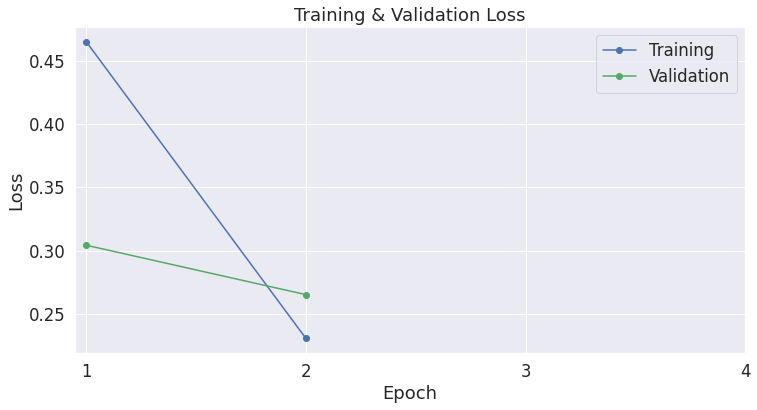

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Evaluation

So as per the above results, our model has a 0.92 accuracy on the validation set. Now let's evaluate it on the test set:

In [ ]:
# Prepare test set for evaluation
import pandas as pd

print('Number of test reviews: {:,}\n'.format(test.shape[0]))

tweets = test.clean_tweets.values
sentiment = test.Sentiment.values

test_input_ids = []
test_attention_masks = []

# For every tweet...
for tweet in tweets:
  encoded = tokenizer.encode_plus(tweet, 
                                  add_special_tokens=True, 
                                  max_length=MAX_LEN, 
                                  padding='max_length', 
                                  return_attention_mask=True, 
                                  return_tensors='pt')
  
  test_input_ids.append(encoded['input_ids'])
  test_attention_masks.append(encoded['attention_mask'])

# Convert to tensor
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
sentiment = torch.tensor(sentiment)

batch_size = 16

# Create DataLoader
prediction_data = TensorDataset(test_input_ids, test_attention_masks, sentiment)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test reviews: 3,781



### Predictions on test set

**NOTE**: To increase performance we can train the model on the full training set (training set that we used for training + the validation set).

In [ ]:
# Prediction on test set

print('Predicting sentiment for {:,} test reviews...'.format(len(input_ids)))

model.eval()

# Tracking variables 
predictions , true_sentiment = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack inputs from dataloader
  b_input_ids, b_input_mask, b_sentiment = batch
  
  # Telling model not to compute or store gradients (save memory & speed up predicting)
  with torch.no_grad():
    # Forward pass, calculate logit predicitions
    result = model(b_input_ids, 
                   token_type_ids=None, 
                   attention_mask=b_input_mask, 
                   return_dict=True)
  
  logits = result.logits

  # Move logits & sentiment to CPU
  logits = logits.detach().cpu().numpy()
  sentiment_ids = b_sentiment.to('cpu').numpy()

  # Store predicition & true sentiment
  predictions.append(logits)
  true_sentiment.append(sentiment_ids)

print('   DONE.')

Predicting sentiment for 3,781 test reviews...
   DONE.


In [ ]:
len(predictions) # Length of individual batches (combine all batches and get full test set predicitons => np.concatenate(predictions, axis=0))

237

In [ ]:
len(true_sentiment)

237

In [ ]:
pred_sentiment = []

for i in range(len(true_sentiment)):

  pred_sentiment.append(np.argmax(predictions[i], axis=1).flatten())

In [ ]:
pred_sentiment

In [ ]:
true_sentiment

In [ ]:
len(pred_sentiment), len(true_sentiment)

(237, 237)

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_sentiment)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_sentiment[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


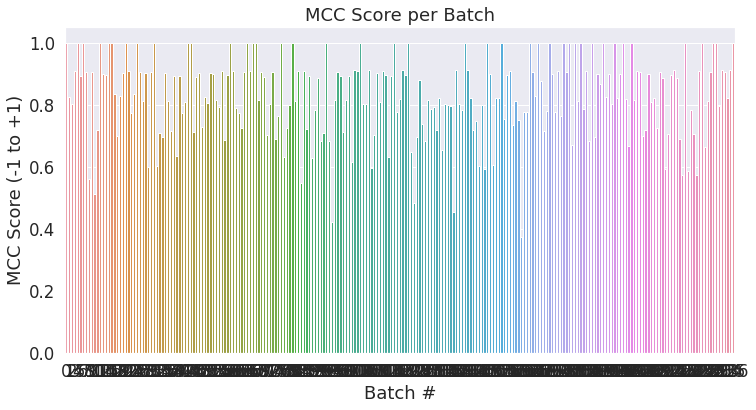

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the sentiment (0, 1, or 2) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_sentiment = np.concatenate(true_sentiment, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_sentiment, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.825


In [ ]:
len(flat_predictions) # Our predictions

3781

In [ ]:
len(flat_true_sentiment) # Test set sentiment to which we compare our predictions

3781

Pretty good considering the MCC is between -1 & 1, with 1 being a perfect prediction, 0 an average random prediction and -1 being an iverse prediction.

NOTE on MCC: MCC is a good metric with **unbalanced** classes as well. SO although we used ROS to balance our classes here, we could have also not balanced them, and used MCC to evaluate either way.

Below we try with different evaluation methods:

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix

# Helper function
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [ ]:
confusion_matrix(flat_true_sentiment, flat_predictions)

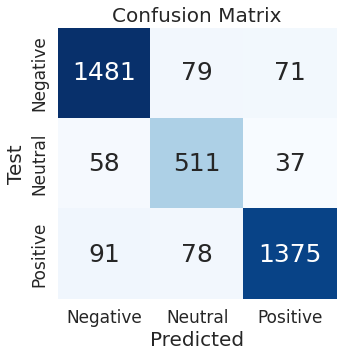

In [ ]:
conf_matrix(flat_true_sentiment, flat_predictions, 'Confusion Matrix')

Again, we see the model performs well!